2024-02-13 03:40:25.752366: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 03:40:25.752439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 03:40:25.887791: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 03:40:26.212359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-13 03:40:28.560473: W tensorflow/comp

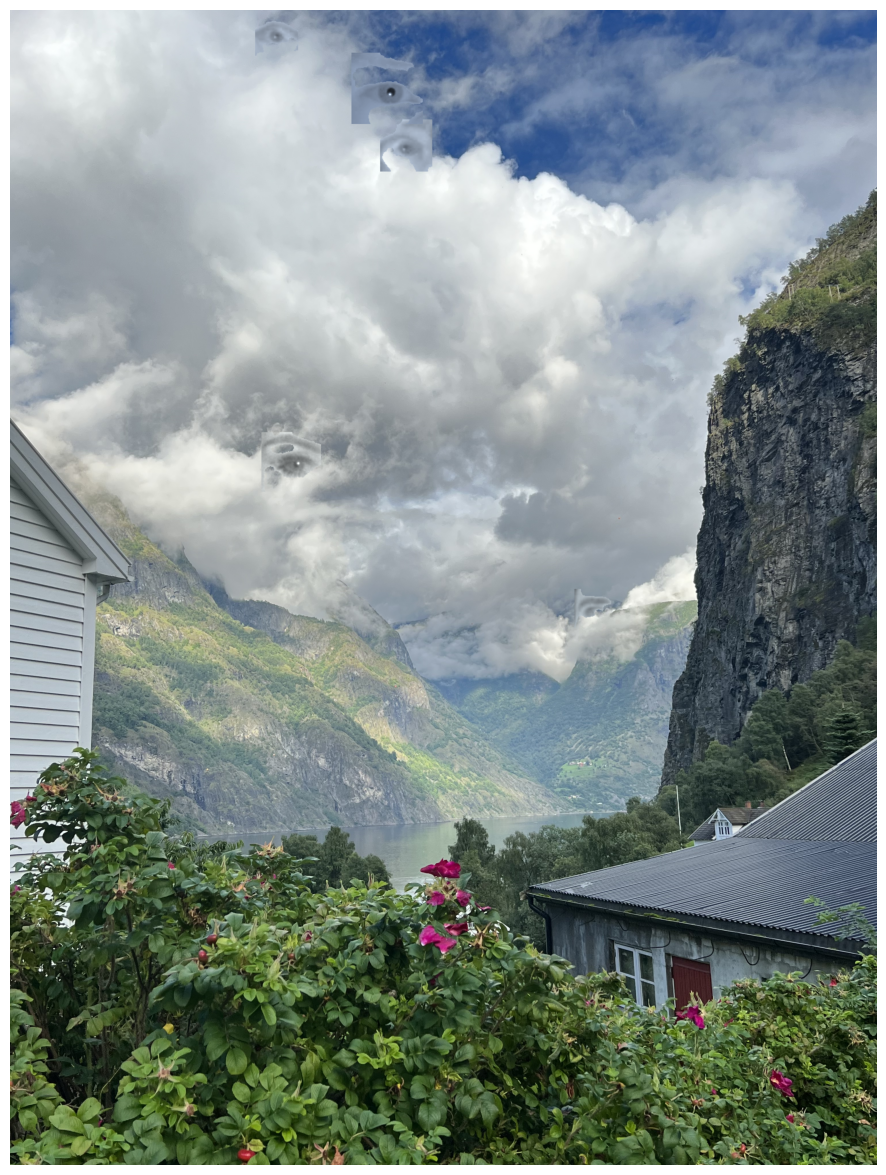

In [3]:
import cv2
import numpy as np
import os
import random
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt

# This line ensures that the plot is displayed in full width
plt.rcParams['figure.figsize'] = [20, 15]  # You can adjust the values here as needed

# Load the image
image = Image.open("NatGeo/aeye1.jpg")  # Replace with your image path
image = image.rotate(-90, expand=True)
image_array = np.array(image)

# Preprocess the image
image_grayscale = tf.image.rgb_to_grayscale(image_array)
image_normalized = tf.cast(image_grayscale, tf.float32) / 255.0

# Get the base directory where OpenCV is installed
cv2_base_dir = os.path.dirname(os.path.abspath(cv2.__file__))

# Path to the Eye Detection Haar Cascade XML file
haar_model = os.path.join(cv2_base_dir, 'data/haarcascade_eye.xml')

# Create a CascadeClassifier object for eye detection
eye_cascade = cv2.CascadeClassifier(haar_model)

# Check if the cascade is loaded correctly
if eye_cascade.empty():
    raise ValueError("The Eye Detection Haar Cascade XML file could not be loaded.")

# Convert image to grayscale for OpenCV processing
image_array_gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)

# Detect eyes in the image
eyes = eye_cascade.detectMultiScale(image_array_gray, scaleFactor=1.07, minNeighbors=4, minSize=(120, 120))

def match_color(target, source, mask=None):
    """
    Adjust the color balance and brightness of the source to match the target.
    """
    if mask is not None:
        mask = mask.astype(bool)
        source = source * mask[:, :, None]  # Apply mask to source
        target = target * mask[:, :, None]  # Apply mask to target

    # Convert to float to prevent clipping values
    source = source.astype('float32')
    target = target.astype('float32')

    # Split channels
    source_channels = cv2.split(source)
    target_channels = cv2.split(target)

    # Calculate mean and standard deviation of each channel
    output_channels = []
    for s_channel, t_channel in zip(source_channels, target_channels):
        s_mean, s_std = cv2.meanStdDev(s_channel)
        t_mean, t_std = cv2.meanStdDev(t_channel)

        # Normalize channels
        s_channel = (s_channel - s_mean) / (s_std + 1e-6)
        t_channel = s_channel * t_std + t_mean

        # Clip values to [0, 255]
        t_channel = np.clip(t_channel, 0, 255)

        output_channels.append(t_channel)

    # Merge channels
    matched = cv2.merge(output_channels).astype('uint8')

    return matched

def overlay_image(background, overlay, x, y, w, h, alpha=0.5):
    # Resize the overlay to fit the region of interest
    overlay_resized = cv2.resize(overlay, (w, h))

    # Check if the overlay image has an alpha channel
    if overlay_resized.shape[2] == 4:
        overlay_alpha = overlay_resized[:, :, 3] / 255.0
        overlay_image = overlay_resized[:, :, :3]
    else:
        overlay_alpha = np.full((overlay_resized.shape[0], overlay_resized.shape[1]), alpha, dtype=np.float32)
        overlay_image = overlay_resized

    # Extract the region of interest from the background
    background_part = background[y:y+h, x:x+w]

    # Match the color of the overlay with the part of the background it will be placed on
    overlay_image_matched = match_color(background_part, overlay_image, mask=overlay_alpha)

    # Perform the overlay using the alpha channel
    for c in range(3):  # loop over color channels
        background_part[:, :, c] = (overlay_image_matched[:, :, c] * overlay_alpha +
                                    background_part[:, :, c] * (1 - overlay_alpha))

    # Place the blended part back into the background image
    background[y:y+h, x:x+w] = background_part

    return background  # Return the modified background

# Before the loop, check if image_array is valid
if image_array is None:
    raise ValueError("image_array is None. Ensure that the image is loaded correctly.")

# Loop over detected eyes and apply the overlay
for (x, y, w, h) in eyes:
    random_eye_image_path = os.path.join("result", random.choice(os.listdir("result")))
    random_eye_image = cv2.imread(random_eye_image_path, cv2.IMREAD_UNCHANGED)  # Load with alpha channel if present

    if random_eye_image is None:
        print(f"Failed to load image from {random_eye_image_path}")
        continue

     # Overlay the image and update image_array with the result
    image_array = overlay_image(image_array, random_eye_image, x, y, w, h, alpha=0.50)

# Display the image with overlays
plt.imshow(image_array)
plt.axis('off')  # Removes the axis labels
plt.show()



In [2]:
jupyter nbconvert --to script Aeye2.ipynb


SyntaxError: invalid syntax (3444317829.py, line 1)